# **Modelos Avanzados de Aprendizaje Automático I**


**Rafael Balseiro Couceiro** <br>
**Iván Mandayo Lagoa** <br>
**Alba ... ...**

# **Práctica 2: Reconocimiento de movimiento a partir de sensores de smartphones**

In [1]:
# Check enviroment
using Pkg
Pkg.status()

Status `~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/Project.toml`
  [336ed68f] CSV v0.10.15
  [324d7699] CategoricalArrays v1.0.2
  [a93c6f00] DataFrames v1.8.1
  [587475ba] Flux v0.16.5
  [38e38edf] GLM v1.9.0
  [09f84164] HypothesisTests v0.11.6
⌃ [7073ff75] IJulia v1.32.1
  [96684042] InformationMeasures v0.3.1
  [c8e1da08] IterTools v1.10.0
  [b1bec4e5] LIBSVM v0.8.1
  [add582a8] MLJ v0.22.0
  [a7f614a8] MLJBase v1.10.0
  [094fc8d1] MLJFlux v0.6.7
  [61c7150f] MLJLIBSVMInterface v0.2.2
  [6ee0df7b] MLJLinearModels v0.10.1
  [e80e1ace] MLJModelInterface v1.12.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.4
  [6f286f6a] MultivariateStats v0.10.3
  [636a865e] NearestNeighborModels v0.2.3
  [3bd65402] Optimisers v0.4.6
  [ccf2f8ad] PlotThemes v3.3.0
⌃ [91a5bcdd] Plots v1.41.1
  [10745b16] Statistics v1.11.1
  [2913bbd2] StatsBase v0.34.8
  [f3b207a7] StatsPlots v0.15.8
  [bd369af6] Tables v1.12.1
  [9a3f8284] Random v1.11.0
Info Packages marke

In [2]:
# Import necessary libraries
using DataFrames: groupby, combine, select!, Not, DataFrame, ncol, nrow, disallowmissing!
using MLJ
using MLJBase
using CSV
using Statistics
using Plots
using Random
using StatsBase
using IterTools
using DataFrames

In [3]:
Random.seed!(104) # For reproducibility

TaskLocalRNG()

## **Preparación de los datos**

### **1. Carga y unificación de los datos**

In [4]:
# Ruta raíz de los datos
DATA_PATH = "../data"

# Recorrer todos los directorios y subdirectorios, y extraer archivos CSV
csv_files = filter(f -> endswith(f, ".csv"), 
                   [joinpath(dir, file) for (dir, _, files) in walkdir(DATA_PATH) for file in files])

# Cargar todos los CSVs en un vector de DataFrames
dataframes = CSV.File.(csv_files) .|> DataFrame

# Concatenar todos los DataFrames en uno solo
full_dataset = vcat(dataframes...)

# Descripción básica
total_features = size(full_dataset, 2)
total_instances = size(full_dataset, 1)
total_individuals = size(unique(full_dataset.subject), 1)
total_targets = size(unique(full_dataset.Activity), 1)

println("Número de variables: ", total_features)
println("Número de instancias: ", total_instances)
println("Número de individuos: ", total_individuals)
println("Número de clases de salida: ", total_targets)



Número de variables: 563
Número de instancias: 10299
Número de individuos: 30
Número de clases de salida: 6


### **2. Análisis de missing values**

In [5]:
# Nombres de columnas
cols = names(full_dataset)
missing_counts = count.(ismissing, eachcol(full_dataset))

missing_percent = Dict(cols[i] => 100 * missing_counts[i] / total_instances for i in eachindex(cols))

# Porcentaje de missing total
total_missing_percent = 100 * sum(missing_counts) / (total_instances * ncol(full_dataset))

# Mostrar resultados
for (col, pct) in sort(collect(missing_percent), by=x->x[2], rev=true)
    if pct > 0.0
        println(col, ": ", round(pct, digits=2), "%")
    end
end

println("\nTotal Missing Values (%): ", round(total_missing_percent, digits=2), "%")

tBodyGyroMag-mad(): 10.03%
tBodyGyroMag-iqr(): 10.03%
fBodyAcc-mad()-Y: 10.02%
fBodyAccJerk-mean()-X: 10.02%
tGravityAccMag-std(): 10.0%
tBodyAccJerk-entropy()-Y: 10.0%
tBodyAccMag-max(): 10.0%
fBodyBodyGyroMag-iqr(): 10.0%
tBodyAccJerk-energy()-X: 10.0%
fBodyAcc-std()-X: 10.0%
tGravityAccMag-entropy(): 10.0%
fBodyAcc-maxInds-Y: 9.99%
tBodyAccJerkMag-arCoeff()2: 9.99%
tGravityAcc-arCoeff()-X,3: 9.99%
fBodyGyro-energy()-Y: 9.99%
fBodyGyro-bandsEnergy()-49,56.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8: 9.99%
fBodyAccMag-max(): 9.99%
tGravityAcc-mad()-Z: 9.99%
tBodyGyroJerk-arCoeff()-Z,2: 9.99%
tBodyGyro-mean()-Z: 9.99%
fBodyAcc-bandsEnergy()-25,32.2: 9.99%
tBodyGyroJerkMag-arCoeff()1: 9.99%
fBodyAcc-kurtosis()-Y: 9.99%
tBodyAccJerk-arCoeff()-X,4: 9.99%
fBodyGyro-mean()-X: 9.99%
tBodyAcc-correlation()-X,Y: 9.99%
fBodyAccJerk-bandsEnergy()-49,56.2: 9.99%
fBodyAccJerk-bandsEnergy()-9,16.2: 9.99%
fBodyAccJerk-bandsEnergy()-1,24: 9.99%
fBodyAcc-min()-Z: 9.

In [6]:
# Threshold
threshold = 5.0

# Convertimos el diccionario a DataFrame
df_missing = DataFrame(Feature = collect(keys(missing_percent)),
                       MissingPct = collect(values(missing_percent)))

# Categorizar
high_missing = df_missing[df_missing.MissingPct .>= threshold, :]
low_missing  = df_missing[(df_missing.MissingPct .> 0) .& (df_missing.MissingPct .< threshold), :]
no_missing   = df_missing[df_missing.MissingPct .== 0, :]

# Crear tabla resumen
summary_table = DataFrame(
    Category = ["High Missing (>=5%)", "Low Missing (>0% & <5%)", "No Missing (0%)"],
    NumVariables = [nrow(high_missing), nrow(low_missing), nrow(no_missing)],
    MeanMissingPct = [mean(high_missing.MissingPct),
                      mean(low_missing.MissingPct),
                      mean(no_missing.MissingPct)],
    StdMissingPct = [std(high_missing.MissingPct),
                     std(low_missing.MissingPct),
                     std(no_missing.MissingPct)]
)

println(summary_table)


3×4 DataFrame
 Row │ Category                 NumVariables  MeanMissingPct  StdMissingPct 
     │ String                   Int64         Float64         Float64       
─────┼──────────────────────────────────────────────────────────────────────
   1 │ High Missing (>=5%)                56       9.9949        0.00917645
   2 │ Low Missing (>0% & <5%)           119       0.0201537     0.00921659
   3 │ No Missing (0%)                   388       0.0           0.0


### **3. Tratamiento de missing values**

Como hemos visto hay varias features con **valores faltantes**, nuestra estrategia de tratamiento será la siguiente:

- Se asume que los valores nulos siguen un esquema **MCAR** (*Missing Completely at Random*)
- **Threshold**: 5%.
- Si *null_percentage* >= 5%: eliminación de dicha feature.
- Sino si *null_percentage* < 5%: imputación por mediana.

In [7]:

function imputeMCAR(df::DataFrame, missing_percent::Dict{String, Float64}, threshold::Float64=5.0)

    df_clean = deepcopy(df)

    cols = names(df_clean)
    pct_missing = [missing_percent[col] for col in cols]

    # Columnas a eliminar e imputar
    to_drop   = cols[pct_missing .>= threshold]
    to_impute = cols[(pct_missing .> 0.0) .& (pct_missing .< threshold)]

    # Eliminar columnas
    select!(df_clean, Not(to_drop))

    # Informe
    imputed_cols = Dict{String,String}()

    # === IMPUTACIÓN POR INDIVIDUO ===
    # Agrupar por individuo una sola vez para eficiencia
    gdf = groupby(df_clean, :subject)

    for col in to_impute

        for subdf in gdf
            # Calcular mediana del individuo sobre esa variable
            med = median(skipmissing(subdf[!, col]))

            # Índices (globales) donde ese individuo tiene missing en col
            missing_idx = findall(ismissing, subdf[!, col])

            # Rellenar solo esos índices en df_clean (subdf es una vista)
            for idx in missing_idx
                subdf[idx, col] = med
            end
        end

        # Registrar imputación
        imputed_cols[col] = "median_by_individual"
    end

    DataFrames.disallowmissing!(df_clean)

    # Reporte final
    report = Dict(
        "eliminated_columns" => to_drop,
        "imputed_columns" => imputed_cols,
        "num_eliminated" => length(to_drop),
        "num_imputed" => length(imputed_cols)
    )

    return df_clean, report
end

imputeMCAR (generic function with 2 methods)

Ahora, ya diseñado el pipeline de limpieza de valores nulos, lo aplicaremos:

In [8]:
# Suponiendo que full_dataset y missing_percent ya están definidos
threshold = 5.0
clean_df, imputation_report = imputeMCAR(full_dataset, missing_percent, threshold)

println("Dropped features: ", imputation_report["num_eliminated"])
println("Imputed features: ", imputation_report["num_imputed"])
println("New feature space dimension: ", size(clean_df, 2))

Dropped features: 56
Imputed features: 119
New feature space dimension: 507


Podemos observar que el número de columnas, tanto eliminadas como imputadas **coincide** con el análisis hecho con el dataset completo anteriormente.

Para asegurarnos por completo, contaremos el número de **missing values**, puediendo asegurar que es ahora **0**.

In [9]:
# Contar la cantidad de missing values
missing_values = sum(count.(ismissing, eachcol(clean_df)))
println("\nTotal Missing Values: ", missing_values)


Total Missing Values: 0


### **4. Partición del conjunto**

In [10]:
function train_test_split(df::DataFrame, test_size::Float64=0.1)

    Random.seed!(104) 
    individuals = unique(df.subject)
    Random.shuffle!(individuals)
    n_test = Int(floor(length(individuals) * test_size))
    test_individuals = individuals[1:n_test]
    train_individuals = individuals[(n_test+1):end]
    train_df = df[in.(df.subject, Ref(train_individuals)), :]
    test_df = df[in.(df.subject, Ref(test_individuals)), :]
    return (train_df, test_df)

end

train_test_split (generic function with 2 methods)

In [11]:
function cross_validation_folds(df::DataFrame, k::Int=5)
    
    Random.seed!(104)
    
    # 1. Asignación aleatoria de individuos a folds
    folds = 1:k
    individuals = unique(df.subject)
    k_folds = repeat(folds, Int(ceil(length(individuals)/k))) 
    k_folds = k_folds[1:length(individuals)] 
    k_folds = shuffle!(k_folds) 

    # Mapeo: ID Sujeto -> Número de Fold (1..k)
    individual_to_fold = Dict(ind => fold for (ind, fold) in zip(individuals, k_folds))
    
    # 2. Generar vector de asignación por fila
    # Para cada fila del DF, miramos a qué fold pertenece su sujeto
    row_fold_assignments = [individual_to_fold[s] for s in df.subject]
    
    # 3. Crear tuplas de índices (Train, Test)
    cv_folds_indices = Vector{Tuple{Vector{Int}, Vector{Int}}}()
    
    for i in 1:k
        # Test: Filas cuyo sujeto cayó en el fold 'i'
        test_idx = findall(row_fold_assignments .== i)
        
        # Train: Filas cuyo sujeto cayó en cualquier OTRO fold
        train_idx = findall(row_fold_assignments .!= i)
        
        push!(cv_folds_indices, (train_idx, test_idx))
    end
    
    return cv_folds_indices    
end

cross_validation_folds (generic function with 2 methods)

In [12]:
train, test = train_test_split(clean_df, 0.1)

# Verificar datasets
println("Individuals in train set: ", length(unique(train.subject)))
println("Individuals in test set: ", length(unique(test.subject)), " | ", unique(test.subject))

println("Train set size: ", size(train))
println("Test set size: ", size(test))

Individuals in train set: 27
Individuals in test set: 3 | [25, 18, 22]
Train set size: (9205, 507)
Test set size: (1094, 507)


In [13]:
# --- Cross-Validation Folds Verification ---

# Generate folds (assuming 'train' DataFrame and 'cross_validation_folds' function exist)
folds = cross_validation_folds(train, 5)

println("CROSS-VALIDATION INTEGRITY CHECK (Group K-Fold / Subject-wise)")
println("="^80)

# Iterating through fold tuples: [(train_idx, test_idx), ...]
for (i, (train_idx, test_idx)) in enumerate(folds)
    
    # Materialize data subsets using indices
    fold_train = train[train_idx, :]
    fold_test  = train[test_idx, :]
    
    # Extract unique subjects in each partition
    subjects_train = sort(unique(fold_train.subject))
    subjects_test  = sort(unique(fold_test.subject))
    
    # Check for intersection (Data Leakage)
    leakage = intersect(subjects_train, subjects_test)
    
    # Print Fold Report
    println("\n[Fold $i]")
    println("  Test Set:       Dimensions: $(size(fold_test))  | Subjects: $subjects_test")
    
    println("-"^80)
end

println("Verification completed.")

CROSS-VALIDATION INTEGRITY CHECK (Group K-Fold / Subject-wise)

[Fold 1]
  Test Set:       Dimensions: (2171, 507)  | Subjects: [6, 7, 16, 21, 24, 30]
--------------------------------------------------------------------------------

[Fold 2]
  Test Set:       Dimensions: (1947, 507)  | Subjects: [2, 9, 10, 13, 26, 29]
--------------------------------------------------------------------------------

[Fold 3]
  Test Set:       Dimensions: (1823, 507)  | Subjects: [1, 17, 20, 23, 28]
--------------------------------------------------------------------------------

[Fold 4]
  Test Set:       Dimensions: (1662, 507)  | Subjects: [3, 5, 12, 14, 27]
--------------------------------------------------------------------------------

[Fold 5]
  Test Set:       Dimensions: (1602, 507)  | Subjects: [4, 8, 11, 15, 19]
--------------------------------------------------------------------------------
Verification completed.


### **5. Exploratory Data Analysis**

Realizaremos un análisis básico de los datos que constará de:

- Exploración de la **distribución de las clases** a lo largo del dataset, lo cuál nos dará información sobre qué métricas emplear.
- **Visualización** de la proyección de los datos en un espacio de **baja dimensionalidad**.

In [14]:
using DataFrames, StatsBase, Statistics
using StatsPlots, PlotThemes
using CategoricalArrays # Necesario para forzar el orden de los ejes

theme(:wong)

# --- Exploratory Data Analysis: Subject-Activity Distribution ---


# 1. Data Aggregation
# ---------------------------------
df_counts = combine(groupby(train, [:subject, :Activity]), nrow => :Count)

# Pivot to matrix format
df_pivot = unstack(df_counts, :subject, :Activity, :Count, fill=0)

# --- CORRECCIÓN: ORDENAR POR INDIVIDUO (NUMÉRICO) ---
sort!(df_pivot, :subject) 

# Extract matrix
# Usamos los datos ya ordenados del pivot
matrix_counts = Matrix(df_pivot[:, Not(:subject)])

# Crear etiquetas ordenadas para el eje
# Convertimos a string para la etiqueta, pero forzamos el orden usando CategoricalArray
# defininedo los 'levels' exactamente en el orden en que aparecen en el DF ordenado.
subjects_sorted = df_pivot.subject
subjects_labels = categorical(string.(subjects_sorted), levels=string.(subjects_sorted), ordered=true)

activities_str = names(df_pivot, Not(:subject))

6-element Vector{String}:
 "STANDING"
 "SITTING"
 "LAYING"
 "WALKING"
 "WALKING_UPSTAIRS"
 "WALKING_DOWNSTAIRS"

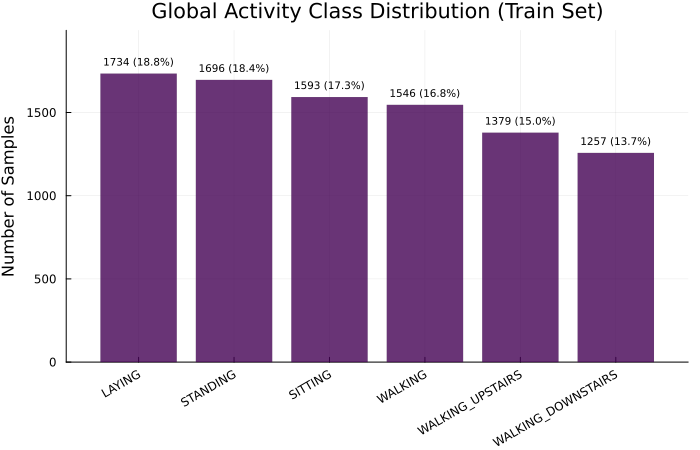

In [15]:
using DataFrames, StatsBase, Statistics
using StatsPlots
using Plots


# 1. Preparación de Datos (Global)
# --------------------------------
# Agrupamos solo por actividad y contamos
df_global = combine(groupby(train, :Activity), nrow => :Count)

# Opcional: Ordenar por cantidad (Pareto) para que se vea más ordenado
sort!(df_global, :Count, rev=true) 

# Extraer datos
activities = df_global.Activity
counts = df_global.Count

# Calcular porcentajes para las etiquetas
total_samples = sum(counts)
percentages = round.((counts ./ total_samples) * 100, digits=1)
labels_text = string.(counts, " (", percentages, "%)")

# 2. Visualización: Gráfico de Barras Global
# ------------------------------------------
p_global = bar(
    activities, counts,
    title = "Global Activity Class Distribution (Train Set)",
    xlabel = "Activity Class",
    ylabel = "Number of Samples",
    color = :viridis,
    legend = false,          # No hace falta leyenda para una sola serie
    alpha = 0.8,             # Un poco de transparencia queda elegante
    linewidth = 0,           # Sin bordes negros
    xrotation = 30,          # Rotar etiquetas para que no se solapen
    size = (700, 450)
)

# Añadir etiquetas de valor encima de cada barra (Annotate)
# Esto es muy útil en papers para ver el número exacto sin mirar el eje Y
annotations = [
    (x, y + (maximum(counts)*0.02), text(lbl, 7, :black, :bottom)) 
    for (x, y, lbl) in zip(activities, counts, labels_text)
]
annotate!(annotations)

# Ajustar el límite superior del eje Y para que quepan las etiquetas
ylims!(0, maximum(counts) * 1.15)

# Mostrar
display(p_global)

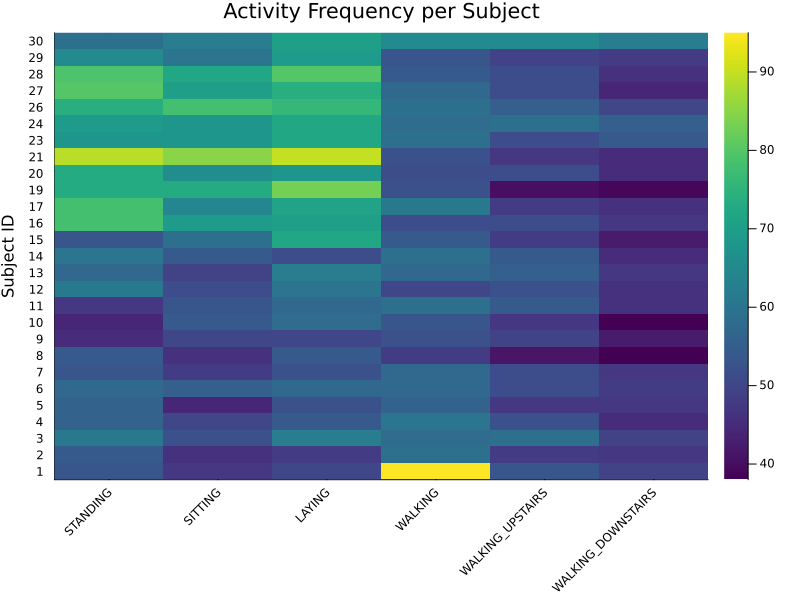

In [16]:
# 2. Visualization: Activity Frequency Heatmap
# -------------------------------------------
p1 = heatmap(
    activities_str, subjects_labels, matrix_counts,
    title  = "Activity Frequency per Subject",
    xlabel = "Activity",
    ylabel = "Subject ID",
    color = :viridis,
    xrotation = 45,
    size = (800, 600)
)

# Display plots
display(p1)


In [17]:
global_counts = combine(groupby(train, :Activity), nrow => :Count)
min_c = minimum(global_counts.Count)
max_c = maximum(global_counts.Count)
imbalance_ratio = max_c / min_c

println("Global Imbalance Ratio (Max/Min class): $(round(imbalance_ratio, digits=2))")

Global Imbalance Ratio (Max/Min class): 1.38


## **Experimentos con modelos básicos**

### **1. Reducción por filtrado**

In [19]:
include("../src/filterWrappers.jl")
using .FilteringReduction: PearsonSelector, SpearmanSelector, KendallSelector, ANOVASelector, MutualInfoSelector, RFELogistic

include("../src/dimReduction.jl")
using .ProyectionReduction: get_lda_model, get_pca_model, get_ica_model

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


In [ ]:
using Tables           # Sustituye la dependencia fuerte de DataFrames
using CategoricalArrays
using MLJ

# Asumimos que 'train' existe (aunque sea un DataFrame, lo trataremos como Tabla genérica)

# ==============================================================================
# 1. SEPARAR X (Features) COMO TABLA GENÉRICA
# ==============================================================================

# 1. Convertimos 'train' a una ColumnTable (NamedTuple de vectores).
# Esto es lo que MLJ entiende mejor como "Tabla pura".
train_tbl = Tables.columntable(train)
all_cols = keys(train_tbl) 
x_cols = filter(c -> c ∉ [:subject, :Activity], all_cols)
inputs = NamedTuple{x_cols}(train_tbl)

# ==============================================================================
# 2. SEPARAR Y TRANSFORMAR Y (Target Ordenado)
# ==============================================================================

# Extraemos la columna :Activity de forma genérica
y_raw = Tables.getcolumn(train_tbl, :Activity)

# Definimos el orden explícito
niveles_ordenados = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Crea un diccionario de codificación
label_to_int = Dict(niveles_ordenados .=> 1:length(niveles_ordenados))

# Codifica y
y = [label_to_int[label] for label in y_raw]
y = categorical(y, ordered=true)

# Verificamos dimensiones y tipo
println("Niveles en y: ", levels(y))
println("Dimensiones de y: ", size(y))
println("Tipo de inputs: ", typeof(inputs)) 

Niveles en y: CategoricalValue{Int64, UInt32}[1, 2, 3, 4, 5, 6]
Dimensiones de y: (9205,)
Tipo de inputs: @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Fl

### **1. Prueba de reducción por filtrado**

In [26]:
using Statistics
using MLJ
using MLJLinearModels


# 1. Definición de selectores (Añadimos el RFE al final)
selectors = [
    ("Pearson (Lineal)",             PearsonSelector(k=20)),
    ("Spearman (Monotónico)",        SpearmanSelector(k=20)),
    ("Kendall (Ordinal)",            KendallSelector(k=20)),
    ("ANOVA (Significancia)",        ANOVASelector(k=20)),
    ("Mutual Info (No Lineal)",      MutualInfoSelector(k=20)),
    # RFE: Importante, step=0.5 elimina el 50% en cada pasada
    ("RFE (Logit 1vsRest)",          RFELogistic(k=20, step=0.5)) 
]

println("🔍 DIAGNÓSTICO DE FILTROS (TIPO MIXTO: SIMPLES + RFE)")
println("="^80)

for (name, model) in selectors
    println("\n🔷 $name")
    println("-"^60)
    
    try
        # 1. Crear Máquina y Entrenar
        mach = machine(model, inputs, y)
        fit!(mach, verbosity=0)
        
        # 2. Leer el Reporte
        rep = MLJ.report(mach)
        
        # --- LÓGICA DE ADAPTACIÓN DEL REPORTE ---
        
        # A. Obtener Conteos (Input / Output)
        # El input siempre es el ancho de tus datos originales
        n_in = size(MLJ.matrix(inputs), 2) 
        
        # El output depende del tipo de reporte:
        n_out = size(MLJ.matrix(MLJ.transform(mach, inputs)), 2)
        
        
        println("   ✅ Status: OK")
        println("   📉 Reducción: $n_in -> $n_out features conservadas.")
        
        # B. Obtener Scores para Estadísticas
        # Estandarizamos todo a un Vector{Float64}
        vals = Float64[]
        metric_name = "Scores"

        raw_scores = if hasproperty(rep, :scores)
            rep.scores
        elseif hasproperty(rep, :p_values)
            metric_name = "P-Values"
            rep.p_values
        else
            []
        end
        
        # Procesar según la estructura de los scores
        if raw_scores isa AbstractVector{<:Number}
            # Caso Simple: Vector de números [0.5, 0.9, ...]
            vals = Float64.(raw_scores)
            
        elseif raw_scores isa AbstractDict
            # Caso RFE (A veces): Dict(:Age => 0.5, ...)
            vals = Float64.(collect(values(raw_scores)))
            
        elseif raw_scores isa AbstractVector{<:Pair}
            # Caso RFE (Estándar MLJ): [:Age => 0.5, :Tenure => 0.2]
            # Tomamos el último elemento del par (el valor)
            vals = Float64.(last.(raw_scores))
        end

        # 3. Imprimir Estadísticas
        if !isempty(vals)
            # Limpieza de NaNs por seguridad
            filter!(!isnan, vals)
            
            if isempty(vals)
                println("   ⚠️ Scores disponibles pero todos eran NaN.")
            else
                v_min  = minimum(vals)
                v_max  = maximum(vals)
                v_mean = mean(vals)
                v_std  = std(vals)
                
                println("   📊 Estadísticas de $metric_name:")
                println("      Min:  $(round(v_min, digits=4))")
                println("      Max:  $(round(v_max, digits=4))")
                println("      Mean: $(round(v_mean, digits=4))")
                println("      Std:  $(round(v_std, digits=4))")
            end
        else
            println("   ℹ️  No se encontraron scores numéricos en el reporte.")
        end
        
        if n_out == 0
            println("   ⚠️ ALERTA: El filtro ha eliminado TODAS las variables.")
        end

    catch e
        println("   ❌ ERROR CRÍTICO: $e")
        # Descomenta la línea de abajo para ver el detalle completo del error si falla
        Base.showerror(stdout, e, catch_backtrace())
    end
end

🔍 DIAGNÓSTICO DE FILTROS (TIPO MIXTO: SIMPLES + RFE)

🔷 Pearson (Lineal)
------------------------------------------------------------
   ✅ Status: OK
   📉 Reducción: 505 -> 20 features conservadas.
   📊 Estadísticas de Scores:
      Min:  0.0009
      Max:  0.895
      Mean: 0.5546
      Std:  0.2687

🔷 Spearman (Monotónico)
------------------------------------------------------------
   ✅ Status: OK
   📉 Reducción: 505 -> 20 features conservadas.
   📊 Estadísticas de Scores:
      Min:  0.0006
      Max:  0.8326
      Mean: 0.6078
      Std:  0.2637

🔷 Kendall (Ordinal)
------------------------------------------------------------
   ✅ Status: OK
   📉 Reducción: 505 -> 20 features conservadas.
   📊 Estadísticas de Scores:
      Min:  0.0006
      Max:  0.6759
      Mean: 0.454
      Std:  0.2001

🔷 ANOVA (Significancia)
------------------------------------------------------------
   ✅ Status: OK
   📉 Reducción: 505 -> 20 features conservadas.
   📊 Estadísticas de Scores:
      Min:  0.

┌ Error: Problem fitting the machine machine(MultinomialClassifier(lambda = 1.0, …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:695
[ Info: Running type checks... 
[ Info: Type checks okay. 
┌ Error: Problem fitting the machine machine(ProbabilisticRecursiveFeatureElimination(model = LogisticRFE(lambda = 1.0, …), …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:695
[ Info: Running type checks... 
[ Info: Type checks okay. 


    @ MLJLinearModels ~/.julia/packages/MLJLinearModels/s9vSj/src/mlj/interface.jl:74
 [14] fit_only!(mach::Machine{MultinomialClassifier, MultinomialClassifier, true}; rows::Nothing, verbosity::Int64, force::Bool, composite::Nothing)
    @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:693
 [15] fit_only!
    @ ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:617 [inlined]
 [16] #fit!#66
    @ ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:790 [inlined]
 [17] fit(model::Main.FilteringReduction.LogisticRFE, verbosity::Int64, X::@NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, va

### **2. Prueba de experimentos**

In [28]:
# 1. Cargar Módulos y Librerías
# Asegúrate de que estas rutas son correctas respecto a tu notebook
include("../src/filterWrappers.jl")
include("../src/dimReduction.jl")
include("../src/modelFactory.jl")
include("../src/experimentLab.jl")
include("../src/scaler.jl")

using .FilteringReduction: PearsonSelector, SpearmanSelector, KendallSelector, ANOVASelector, MutualInfoSelector
using .ProyectionReduction: get_lda_model, get_pca_model, get_ica_model
using .ModelFactory: get_knn_model, get_svm_model, get_mlp_model
using .ExperimentLab: run_experiment_csv
using .CustomScalers: MinMaxScaler

# 2. Instanciar Componentes
# --------------------------

# A. Scaler
scaler = MinMaxScaler()

# B. Filtro Pearson (Usa umbrales estándar para que no filtre demasiado ni poco)
filter = RFELogistic(k=50, step=0.5)

# C. Reductor PCA (15 dimensiones fijas)
reducer = get_pca_model(pratio=0.99) 

# D. Modelo KNN (10 vecinos)
model = get_knn_model(10)

f1_macro = MulticlassFScore(β = 1.0, average = MLJ.MacroAvg())
acc = Accuracy()

# 4. Ejecutar Experimento Único
# --------------------------

res = run_experiment_csv(
    scaler, 
    filter, 
    reducer, 
    model, 
    inputs, y, 
    folds,
    tag = "Test_MI_ICA_KNN",
    metrics = [f1_macro, acc],
    csv_path = "test_results.csv" # Guardamos en otro CSV para no ensuciar el final
)

# 5. Mostrar Resultado
println("\nRESULTADO DE LA PRUEBA:")
println("   Accuracy Medio: $(round(res[:Acc_Mean] * 100, digits=2))%")
println("   Desviación Std: $(round(res[:Acc_Std] * 100, digits=2))%")
println("   f1 (macro) Medio: $(round(res[:Mul_Mean] * 100, digits=2))%")
println("   f1 (macro) Std: $(round(res[:Mul_Std] * 100, digits=2))%")


# CORRECCIÓN AQUÍ: Usamos las nuevas claves estadísticas
# Antes: res[:Feats_Filtered] -> Ahora: res[:Feats_Mean]
println("   Features (Orig -> Filtro -> Red): $(res[:Feats_Original]) -> $(res[:Feats_Mean]) (±$(res[:Feats_Std])) -> $(res[:Dims_Mean]) (±$(res[:Dims_Std]))")

import MLJLinearModels ✔


[ Info: For silent loading, specify `verbosity=0`. 
[ Info: Precompiling MLJFlux [094fc8d1-fd35-5302-93ea-dabda2abf845] 
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MLJFlux [094fc8d1-fd35-5302-93ea-dabda2abf845]
│   exception = Required dependency Base.PkgId(Base.UUID("700de1a5-db45-46bc-99cf-38207098b444"), "ZygoteRules") failed to load from a cache file.
└ @ Base loading.jl:2670
[ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] (cache misses: wrong dep version loaded (2))
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
│   exception = Required dependency Base.PkgId(Base.UUID("700de1a5-db45-46bc-99cf-38207098b444"), "ZygoteRules") failed to load from a cache file.
└ @ Base loading.jl:2670
[ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f] (cache misses: wrong dep version loaded (2))
┌ Warning: The call to compilecache failed t

⚙️ Ejecutando: Test_MI_ICA_KNN ...


┌ Warning: Module Flux with build ID ffffffff-ffff-ffff-d813-ec25b13a6152 is missing from the cache.
│ This may mean Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2613
┌ Info: Skipping precompilation due to precompilable error. Importing Metalhead [dbeba491-748d-5e0e-a39e-b530a07fa0cc].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
┌ Error: Problem fitting the machine machine(MultinomialClassifier(lambda = 1.0, …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:695
[ Info: Running type checks... 
[ Info: Type checks okay. 
┌ Error: Problem fitting the machine machine(:filter, …). 
└ @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:695
[ Info: Running type checks... 
[ Info: Type checks okay. 
┌ Error: Problem fitting machine(:filter, …)
└ @ MLJBase ~/.julia/packages/MLJBase/fpnxN/src/machines.jl:76

LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access Float64 at index [2]
    Stacktrace:
     [1] [0m[1mfit_only![22m[0m[1m([22m[90mmach[39m::[0mMachine[90m{Symbol, Any, false}[39m, [90mwait_on_upstream[39m::[0mBool; [90mkwargs[39m::[0m@Kwargs[90m{verbosity::Int64, composite::Main.ExperimentLab.FlexiblePipeline}[39m[0m[1m)[22m
    [90m   @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:768[24m[39m
     [2] [0m[1mfit_only![22m
    [90m   @[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:747[24m[39m[90m [inlined][39m
     [3] [0m[1m(::MLJBase.var"#90#91"{@Kwargs{verbosity::Int64, composite::Main.ExperimentLab.FlexiblePipeline}, Machine{Symbol, Any, false}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/composition/learning_networks/[39m[90m[4mnodes.jl:237[24m[39m
    
    [91mcaused by: [39mBoundsError: attempt to access Float64 at index [2]
    Stacktrace:
      [1] [0m[1mindexed_iterate[22m[0m[1m([22m[90mI[39m::[0mFloat64, [90mi[39m::[0mInt64, [90mstate[39m::[0mNothing[0m[1m)[22m
    [90m    @[39m [90mBase[39m [90m./[39m[90m[4mtuple.jl:171[24m[39m
      [2] [0m[1m(::LineSearches.var"#ϕdϕ#make_ϕdϕ##0"{Optim.ManifoldObjective{NLSolversBase.OnceDifferentiable{Float64, Vector{Float64}, Vector{Float64}}}, Vector{Float64}, Vector{Float64}, Vector{Float64}})[22m[0m[1m([22m[90mα[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [36mLineSearches[39m [90m~/.julia/packages/LineSearches/2BCHN/src/[39m[90m[4mLineSearches.jl:32[24m[39m
      [3] [0m[1m(::LineSearches.HagerZhang{Float64, Base.RefValue{Bool}})[22m[0m[1m([22m[90mϕ[39m::[0mFunction, [90mϕdϕ[39m::[0mLineSearches.var"#ϕdϕ#make_ϕdϕ##0"[90m{Optim.ManifoldObjective{NLSolversBase.OnceDifferentiable{Float64, Vector{Float64}, Vector{Float64}}}, Vector{Float64}, Vector{Float64}, Vector{Float64}}[39m, [90mc[39m::[0mFloat64, [90mphi_0[39m::[0mFloat64, [90mdphi_0[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [36mLineSearches[39m [90m~/.julia/packages/LineSearches/2BCHN/src/[39m[90m[4mhagerzhang.jl:147[24m[39m
      [4] [0m[1mHagerZhang[22m
    [90m    @[39m [90m~/.julia/packages/LineSearches/2BCHN/src/[39m[90m[4mhagerzhang.jl:103[24m[39m[90m [inlined][39m
      [5] [0m[1mperform_linesearch![22m[0m[1m([22m[90mstate[39m::[0mOptim.LBFGSState[90m{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Float64, Vector{Float64}}[39m, [90mmethod[39m::[0mOptim.LBFGS[90m{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Returns{Nothing}}[39m, [90md[39m::[0mOptim.ManifoldObjective[90m{NLSolversBase.OnceDifferentiable{Float64, Vector{Float64}, Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [32mOptim[39m [90m~/.julia/packages/Optim/7krni/src/utilities/[39m[90m[4mperform_linesearch.jl:58[24m[39m
      [6] [0m[1mupdate_state![22m[0m[1m([22m[90md[39m::[0mNLSolversBase.OnceDifferentiable[90m{Float64, Vector{Float64}, Vector{Float64}}[39m, [90mstate[39m::[0mOptim.LBFGSState[90m{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Float64, Vector{Float64}}[39m, [90mmethod[39m::[0mOptim.LBFGS[90m{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Returns{Nothing}}[39m[0m[1m)[22m
    [90m    @[39m [32mOptim[39m [90m~/.julia/packages/Optim/7krni/src/multivariate/solvers/first_order/[39m[90m[4ml_bfgs.jl:220[24m[39m
      [7] [0m[1moptimize[22m[0m[1m([22m[90md[39m::[0mNLSolversBase.OnceDifferentiable[90m{Float64, Vector{Float64}, Vector{Float64}}[39m, [90minitial_x[39m::[0mVector[90m{Float64}[39m, [90mmethod[39m::[0mOptim.LBFGS[90m{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Returns{Nothing}}[39m, [90moptions[39m::[0mOptim.Options[90m{Float64, Nothing}[39m, [90mstate[39m::[0mOptim.LBFGSState[90m{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Float64, Vector{Float64}}[39m[0m[1m)[22m
    [90m    @[39m [32mOptim[39m [90m~/.julia/packages/Optim/7krni/src/multivariate/optimize/[39m[90m[4moptimize.jl:65[24m[39m
      [8] [0m[1moptimize[22m
    [90m    @[39m [90m~/.julia/packages/Optim/7krni/src/multivariate/optimize/[39m[90m[4moptimize.jl:43[24m[39m[90m [inlined][39m
      [9] [0m[1moptimize[22m[0m[1m([22m[90mf[39m::[0mNLSolversBase.InplaceObjective[90m{Nothing, MLJLinearModels.var"#fg!##0#fg!##1"{GeneralizedLinearRegression{MultinomialLoss{6}, ScaledPenalty{L2Penalty}}, Matrix{Float64}, Vector{Int64}, @NamedTuple{n::Vector{Float64}, n2::Vector{Float64}, n3::Vector{Float64}, p::Vector{Float64}, dims::Tuple{Int64, Int64, Int64}, nc::Matrix{Float64}, nc2::Matrix{Float64}, nc3::Matrix{Float64}, nc4::Matrix{Float64}, pc::Matrix{Float64}}, Float64, Int64, Int64, Int64}, Nothing, Nothing, Nothing}[39m, [90minitial_x[39m::[0mVector[90m{Float64}[39m, [90mmethod[39m::[0mOptim.LBFGS[90m{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Returns{Nothing}}[39m, [90moptions[39m::[0mOptim.Options[90m{Float64, Nothing}[39m; [90minplace[39m::[0mBool, [90mautodiff[39m::[0mSymbol[0m[1m)[22m
    [90m    @[39m [32mOptim[39m [90m~/.julia/packages/Optim/7krni/src/multivariate/optimize/[39m[90m[4minterface.jl:274[24m[39m
     [10] [0m[1moptimize[22m
    [90m    @[39m [90m~/.julia/packages/Optim/7krni/src/multivariate/optimize/[39m[90m[4minterface.jl:264[24m[39m[90m [inlined][39m
     [11] [0m[1m_fit[22m
    [90m    @[39m [90m~/.julia/packages/MLJLinearModels/s9vSj/src/fit/[39m[90m[4mnewton.jl:118[24m[39m[90m [inlined][39m
     [12] [0m[1mfit[22m[0m[1m([22m[90mglr[39m::[0mGeneralizedLinearRegression[90m{MultinomialLoss{6}, ScaledPenalty{L2Penalty}}[39m, [90mX[39m::[0mMatrix[90m{Float64}[39m, [90my[39m::[0mVector[90m{Int64}[39m; [90mdata[39m::[0mNothing, [90msolver[39m::[0mLBFGS[90m{Optim.Options{Float64, Nothing}, @NamedTuple{}}[39m[0m[1m)[22m
    [90m    @[39m [33mMLJLinearModels[39m [90m~/.julia/packages/MLJLinearModels/s9vSj/src/fit/[39m[90m[4mdefault.jl:47[24m[39m
     [13] [0m[1mfit[22m[0m[1m([22m[90mm[39m::[0mMultinomialClassifier, [90mverb[39m::[0mInt64, [90mX[39m::[0m@NamedTuple[90m{var"tBodyAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-maxInds-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-kurtosis()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-kurtosis()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,56"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,56.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-maxInds-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyAccMean,gravity)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyAccJerkMean),gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyGyroMean,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyGyroJerkMean,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(X,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(Y,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(Z,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}[39m, [90my[39m::[0mCategoricalVector[90m{Int64, UInt32, Int64, CategoricalValue{Int64, UInt32}, Union{}}[39m[0m[1m)[22m
    [90m    @[39m [33mMLJLinearModels[39m [90m~/.julia/packages/MLJLinearModels/s9vSj/src/mlj/[39m[90m[4minterface.jl:74[24m[39m
     [14] [0m[1mfit_only![22m[0m[1m([22m[90mmach[39m::[0mMachine[90m{MultinomialClassifier, MultinomialClassifier, true}[39m; [90mrows[39m::[0mNothing, [90mverbosity[39m::[0mInt64, [90mforce[39m::[0mBool, [90mcomposite[39m::[0mNothing[0m[1m)[22m
    [90m    @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:693[24m[39m
     [15] [0m[1mfit_only![22m
    [90m    @[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:617[24m[39m[90m [inlined][39m
     [16] [0m[1m#fit!#66[22m
    [90m    @[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:790[24m[39m[90m [inlined][39m
     [17] [0m[1mfit[22m[0m[1m([22m[90mmodel[39m::[0mMain.FilteringReduction.LogisticRFE, [90mverbosity[39m::[0mInt64, [90mX[39m::[0m@NamedTuple[90m{var"tBodyAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAcc-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAcc-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerk-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyro-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-X,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Y,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Z,1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-arCoeff()-Z,4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-X,Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-X,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerk-correlation()-Y,Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tGravityAccMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyAccJerkMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()3"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-arCoeff()2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"tBodyGyroJerkMag-arCoeff()4"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-maxInds-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-kurtosis()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-9,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,56.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAcc-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-maxInds-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-kurtosis()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,56"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,56.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-1,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccJerk-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mean()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mean()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-std()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-mad()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-max()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-max()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-min()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-energy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-iqr()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-entropy()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-maxInds-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-maxInds-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-meanFreq()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-X"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-Y"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-skewness()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-kurtosis()-Z"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48.1"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,8.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-9,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,40.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-41,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-57,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,16.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-17,32.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-33,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-49,64.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-1,24.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyGyro-bandsEnergy()-25,48.2"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyAccMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyAccJerkMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-energy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-mean()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-std()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-mad()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-max()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-min()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-sma()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-iqr()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-entropy()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-maxInds"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-meanFreq()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-skewness()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"fBodyBodyGyroJerkMag-kurtosis()"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyAccMean,gravity)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyAccJerkMean),gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyGyroMean,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(tBodyGyroJerkMean,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(X,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(Y,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, var"angle(Z,gravityMean)"::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}[39m, [90my[39m::[0mCategoricalVector[90m{Int64, UInt32, Int64, CategoricalValue{Int64, UInt32}, Union{}}[39m[0m[1m)[22m
    [90m    @[39m [36mMain.FilteringReduction[39m [90m~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/src/[39m[90m[4mfilterWrappers.jl:427[24m[39m
     [18] [0m[1mfit[22m[0m[1m([22m::[0mFeatureSelection.ProbabilisticRecursiveFeatureElimination[90m{Main.FilteringReduction.LogisticRFE}[39m, ::[0mInt64, ::[0mTables.MatrixTable[90m{Matrix{Float64}}[39m, ::[0mCategoricalVector[90m{Int64, UInt32, Int64, CategoricalValue{Int64, UInt32}, Union{}}[39m[0m[1m)[22m
    [90m    @[39m [35mFeatureSelection[39m [90m~/.julia/packages/FeatureSelection/1IeeM/src/models/[39m[90m[4mrfe.jl:312[24m[39m
     [19] [0m[1mfit_only![22m[0m[1m([22m[90mmach[39m::[0mMachine[90m{Symbol, Any, false}[39m; [90mrows[39m::[0mNothing, [90mverbosity[39m::[0mInt64, [90mforce[39m::[0mBool, [90mcomposite[39m::[0mMain.ExperimentLab.FlexiblePipeline[0m[1m)[22m
    [90m    @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:693[24m[39m
     [20] [0m[1mfit_only![22m
    [90m    @[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:617[24m[39m[90m [inlined][39m
     [21] [0m[1mfit_only![22m[0m[1m([22m[90mmach[39m::[0mMachine[90m{Symbol, Any, false}[39m, [90mwait_on_upstream[39m::[0mBool; [90mkwargs[39m::[0m@Kwargs[90m{verbosity::Int64, composite::Main.ExperimentLab.FlexiblePipeline}[39m[0m[1m)[22m
    [90m    @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:764[24m[39m
     [22] [0m[1mfit_only![22m
    [90m    @[39m [90m~/.julia/packages/MLJBase/fpnxN/src/[39m[90m[4mmachines.jl:747[24m[39m[90m [inlined][39m
     [23] [0m[1m(::MLJBase.var"#90#91"{@Kwargs{verbosity::Int64, composite::Main.ExperimentLab.FlexiblePipeline}, Machine{Symbol, Any, false}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [35mMLJBase[39m [90m~/.julia/packages/MLJBase/fpnxN/src/composition/learning_networks/[39m[90m[4mnodes.jl:237[24m[39m

  Julia 1.12 has introduced more strict world age semantics for global bindings.
  !!! This code may malfunction under Revise.
  !!! This code will error in future versions of Julia.
Hint: Add an appropriate `invokelatest` around the access to this binding.
To make this warning an error, and hence obtain a stack trace, use `julia --depwarn=error`.


### **3. Experimentos finales**